In [1]:
import ROOT
from root_numpy import root2array, tree2array, root2rec, testdata
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize # MINIMIZATION

Welcome to JupyROOT 6.12/06


## Prepare data structure and functions for single tracking

### Line

In [2]:
class Line:
    def __init__(self, x=0, y=0, z=0, dx=0, dy=0, dz=0, point=[], direction=[], params=[], det_id=0):
        if len(params) == 6:
            self.x,  self.y,  self.z  = params[:3] 
            self.dx, self.dy, self.dz = params[3:]
        elif len(point) == 3 and len(direction) == 3:
            self.x,  self.y,  self.z  = point
            self.dx, self.dy, self.dz = direction
        else:
            self.x,  self.y,  self.z  =  x,  y,  z
            self.dx, self.dy, self.dz = dx, dy, dz
        
        # just to make this line a detector Line
        self.det_id = int(det_id)

    def __repr__(self):
        return "Line: det = {}\t p = ({:.3f}, {:.3f}, {:.3f})\t v = [{:.3f}, {:.3f}, {:.3f}]".format(
            self.det_id, self.x, self.y, self.z, self.dx, self.dy, self.dz
        )
            
    def distance(self, other):
        n_vector = np.cross(self.line_vector(), other.line_vector())
        s_o_vector = np.array([self.x - other.x, self.y - other.y, self.z - other.z])
        return np.linalg.norm( np.dot(n_vector, s_o_vector) ) / np.linalg.norm(n_vector)

    def line_vector(self):
        return np.array([self.dx, self.dy, self.dz])

### Open root file

In [3]:
geometry_root = root2array('det_geometry.root', 'T')
reco_flat = root2array('reco_0_flat.root', 'T')

### Prepare dataframes

In [4]:
geom_df = pd.DataFrame(geometry_root) 
df_all  = pd.DataFrame(reco_flat)

# single_df - data frame with hits which belong to single tracking
single_df = df_all.loc[(df_all['uLineSize'] == 1) & (df_all['vLineSize'] == 1)]

rp_groups = {
    1 : [4, 20, 24],
    2 : [5, 21, 25],
    3 : [3, 22, 23],
    4 : [104, 120, 124],
    5 : [105, 121, 125],
    6 : [103, 122, 123]
}

print("all tracks shape: {}".format(df_all.shape))
print("single tracking shape: {}".format(single_df.shape))


'''
single_groups_df:
    - contains hits for single tracking where each rp from group [top|hor|bot] was hit
    - contains columns: 'eventID', 'groupID', 'counts'
        * groupID - [1-6] id of group to which belong rpID of given hit
        * counts - how many rp's from group was hit
'''

single_groups_df = single_df[['eventID', 'groupID', 'rpID']]\
    .drop_duplicates()\
    .groupby(['eventID', 'groupID'])\
    .size()\
    .reset_index(name='counts')

single_groups_df = single_groups_df.loc[(single_groups_df['counts'] == 3)]

all tracks shape: (5542, 10)
single tracking shape: (5097, 10)


### Hit lines from dataframes
Needed: geometry of detectors and hit positions

In [5]:
DET_Z_TRANSLATION = 0 # SET WITHIN EVENT PROCESSING

def get_hit_lines(single_hits_df, geom_df):
    '''
        reco_0_flat.root:     recoID  eventID  armID  groupID  rpID  uLineSize  vLineSize  siliconID   position  sigma_
        det_geometry.root:    detId   x        y      z        dx    dy
    '''
    
    hit_lines = []

    for h_index, h_row in single_hits_df.iterrows():
        
        h_position = h_row['position']
        det_ID = 10 * h_row['rpID'] + h_row['siliconID']        
        det_info = geom_df.loc[(geom_df['detId'] == det_ID)].iloc[0]

        x = det_info['x'] + h_position * det_info['dx']  # x [mm]
        y = det_info['y'] + h_position * det_info['dy']  # y [mm] 
        
        z = det_info['z'] * 1000 + DET_Z_TRANSLATION     # z [mm] with translation to operate on smaller numbers
        dx = det_info['dx']  
        dy = det_info['dy'] 
        dz = 0
        
        new_line = Line(x, y, z, dx, dy, dz, det_id=det_ID)
        hit_lines.append(new_line)
        
    return hit_lines

### Printing fitting solution

In [6]:
class Hit:
    def __init__(self, x=0, y=0, z=0):
        self.x = x
        self.y = y
        self.z = z


def print_pretty_solution(solution, geom_df):
    print("FULL SOLUTION: \n{}".format(solution))
    print("Sum of distances: {}".format(solution.fun))
    print("Solution: [\n\tx = {}\n\ty = {} \n\tz = {} \n\tdx = {} \n\tdy = {} \n\tdz = {} ]".format(
        solution.x[0],
        solution.x[1],
        solution.x[2] - DET_Z_TRANSLATION,
        solution.x[3],
        solution.x[4],
        solution.x[5])
    )
    print("]")
    print("Distances from detector lines and hit position")
    print("ID\tDistance from hit line [mm]\t x [mm]\t\ty [mm]\t\tz [m]")

    plane_hit = Hit()

    for line in LINE_SET:
        sol_x, sol_y, sol_z = solution.x[0], solution.x[1], solution.x[2]
        sol_dx, sol_dy, sol_dz = solution.x[3], solution.x[4], solution.x[5]
        
        det_info = geom_df.loc[(geom_df['detId'] == line.det_id)].iloc[0]
        det_z = det_info['z']
        k = (det_z - (sol_z - DET_Z_TRANSLATION)) / sol_dz

        # ile jest rowne z a ile k
        # print("det_z = {}\tk = {}".format(det_z, k))
        
        plane_hit.x = sol_x + k * sol_dx
        plane_hit.y = sol_y + k * sol_dy
        plane_hit.z = det_z

        print("{}\t{:.5f}\t\t\t\t({:.5f}\t{:.5f}\t{})".format(line.det_id,
                                                              Line(params=solution.x).distance(line),
                                                              plane_hit.x,
                                                              plane_hit.y,
                                                              plane_hit.z))
    print("\n")

### Minimization for each rp group where is single-tracking 

In [12]:
# REQUIRED BY MY CHI2 FUNCTION
LINE_SET = []

# OBJECTIVE FUNCTION
def chi2(params):
    # TO DO: make it real chi2
    line = Line(params=params)                                  # CREATING FITTED LINE FROM PARAMS
    return np.sum([line.distance(other) for other in LINE_SET]) # SUM OF DISTANCES


def get_constraints():
    # CONSTRAINTS
    def constraint1(params):
        return 1.0 - np.sum([dir**2 for dir in params[3:]]) # dx^2 + dy^2 + dz^2 = 1

    con1 = {'type': 'eq', 'fun':constraint1}
    return [con1]


def get_bounds():
    # BOUND FOR PARAMETERS
    b_x   = (   -50.0,    50.0)
    b_y   = (   -50.0,    50.0)
    b_z   = (-20000.0, 20000.0)
    b_dir = (    -1.0,     1.0)
    return (b_x, b_y, b_z, b_dir, b_dir, b_dir)


# FOR EACH EVENT AND GROUP CALCULATE LINE
row_number = 0

group_distances = {
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : [],
    6 : []
}

# soo there is an error, and an error is big... we want to know to which lines is it related
def get_x0(first_hit_info, geom_df):
    
    det_id   = first_hit_info['rpID'] * 10 + first_hit_info['siliconID'] 
    det_info = geom_df.loc[(geom_df['detId'] == det_id)].iloc[0]
    
    det_x = det_info['x']
    det_y = det_info['y']
    det_z = det_info['z'] * 1000 + DET_Z_TRANSLATION 
    
    return [det_x, det_y, det_z, 0.0, 0.0, np.sign(det_z)]


for index, row in single_groups_df.iterrows():
    # GETTING HITS FOR SPECIFIED GROUP AND EVENT
    eventID, groupID = row['eventID'], row['groupID']
    single_hits_df = single_df.loc[(single_df['eventID'] == eventID) & (single_df['groupID'] == groupID)]
    
    # APPLYING Z TRANSLATION --> WE DO NOT WANT SUCH BIG NUMBERS (|Z| ~ 210 000 [mm])
    if groupID > 3:
        DET_Z_TRANSLATION = -210000
    else:
        DET_Z_TRANSLATION = 210000
    
    LINE_SET = get_hit_lines(single_hits_df, geom_df)    
    
    # SEED SOLUTION - CENTER OF FIRST PLANE [x, y, z] AND DIRECTION ALONG THE BEAM [0, 0, [+|-] 1] 
    x0 = get_x0(single_hits_df.iloc[0], geom_df)    
    solution = minimize(chi2, x0, method='SLSQP', constraints=get_constraints(), bounds=get_bounds())
        
    print("Row number {}\tDistances sum: {}\tSuccess: {}".format(row_number, solution.fun, solution.success))
    # print_pretty_solution(solution, geom_df)
    row_number = row_number + 1


print("THE END")


Row number 0	Distances sum: 21.1351843523	Success: True
Row number 1	Distances sum: 32.3807189903	Success: False
Row number 2	Distances sum: 10.8754924488	Success: True
Row number 3	Distances sum: 17.6933565541	Success: True
Row number 4	Distances sum: 37.5727955552	Success: True
Row number 5	Distances sum: 15.8594947536	Success: True
Row number 6	Distances sum: 31.5439954133	Success: True
Row number 7	Distances sum: 60.2704673441	Success: True
Row number 8	Distances sum: 30.7992471785	Success: True
Row number 9	Distances sum: 22.2995361863	Success: False
Row number 10	Distances sum: 11.3444431595	Success: True
Row number 11	Distances sum: 15.8776215417	Success: True
Row number 12	Distances sum: 21.2135730429	Success: False
Row number 13	Distances sum: 22.3279955338	Success: True
Row number 14	Distances sum: 22.0693317835	Success: True
Row number 15	Distances sum: 22.3067059822	Success: True
Row number 16	Distances sum: 19.1503271519	Success: False
Row number 17	Distances sum: 22.31145

Row number 144	Distances sum: 17.6679151107	Success: True
Row number 145	Distances sum: 21.9472976659	Success: False
Row number 146	Distances sum: 11.1487001222	Success: True
Row number 147	Distances sum: 22.751356573	Success: True
Row number 148	Distances sum: 17.6679274958	Success: True
Row number 149	Distances sum: 37.5728196921	Success: True
Row number 150	Distances sum: 17.6682486471	Success: True
Row number 151	Distances sum: 21.8300329609	Success: True
Row number 152	Distances sum: 26.8259335298	Success: True
Row number 153	Distances sum: 22.0977245132	Success: True
Row number 154	Distances sum: 27.2695495971	Success: True
Row number 155	Distances sum: 15.4972575782	Success: True
THE END


#### left bottom (RP IDs: 25, 21, 5)

In [10]:
left_bottom_df = df_all.loc[(df_all['groupId'] == 2) & (df_all['arm'] == 0) & (df_all['uLinesSize'] > 1) & (df_all['vLinesSize'] > 1)]
left_bottom = left_bottom_df.drop_duplicates(subset=['recoId','eventId'], keep="first").shape[0]

#### left horizontal (RP IDs: 23, 22, 3)

In [11]:
left_horizontal_df = df_all.loc[(df_all['groupId'] == 3) & (df_all['arm'] == 0) & (df_all['uLinesSize'] > 1) & (df_all['vLinesSize'] > 1)]
left_horizontal = left_horizontal_df.drop_duplicates(subset=['recoId','eventId'], keep="first").shape[0]
left_horizontal

16389

#### right top (RP IDs: 104, 120, 124)

In [12]:
right_top_df = df_all.loc[(df_all['groupId'] == 1) & (df_all['arm'] == 1) & (df_all['uLinesSize'] > 1) & (df_all['vLinesSize'] > 1)]
right_top = right_top_df.drop_duplicates(subset=['recoId','eventId'], keep="first").shape[0]
right_top

25054

#### right bottom (RP IDs: 105, 121, 125)

In [13]:
right_bottom_df = df_all.loc[(df_all['groupId'] == 2) & (df_all['arm'] == 1) & (df_all['uLinesSize'] > 1) & (df_all['vLinesSize'] > 1)]
right_bottom = right_bottom_df.drop_duplicates(subset=['recoId','eventId'], keep="first").shape[0]
right_bottom

24439

#### right horizontal (RP IDs: 103, 122, 123)

In [14]:
right_horizontal_df = df_all.loc[(df_all['groupId'] == 3) & (df_all['arm'] == 1) & (df_all['uLinesSize'] > 1) & (df_all['vLinesSize'] > 1)]
right_horizontal = right_horizontal_df.drop_duplicates(subset=['recoId','eventId'], keep="first").shape[0]
right_horizontal

16092

## Plot number of events in each group

In [15]:
events_no_in_left = [left_top, left_horizontal, left_bottom]
events_no_in_left

[23726, 16389, 23989]

In [16]:
events_no_in_right = [right_top, right_horizontal, right_bottom]
events_no_in_right

[25054, 16092, 24439]

In [17]:
# draw bar chart
def gen_plot_for_arm(events_no, title, file_name):
    objects = ('top', 'horizontal', 'bottom')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, events_no, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Number of events')
    plt.title(title)
    
    plt.savefig(file_name)
    plt.show()

### Number of events with multi-track in left arm
#### number of all events (single and multi): 1 000 000

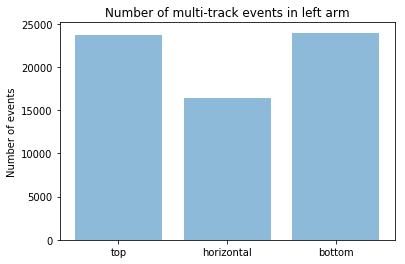

In [18]:
# left_top, left_horizontal, left_bottom

gen_plot_for_arm(events_no_in_left, 'Number of multi-track events in left arm', 'left_arm_plot_100_104.png')


### Number of events with multi-track in right arm
#### number of all events (single and multi): 1 000 000

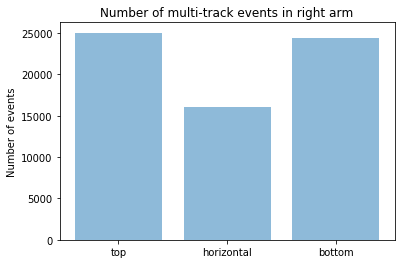

In [19]:
# right_top, right_horizontal, right_bottom

gen_plot_for_arm(events_no_in_right, 'Number of multi-track events in right arm', 'right_arm_plot_100_104.png')